# Image Captioning using InceptionV3

In [1]:
from numpy import array 
from pickle import load
from pickle import dump
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from numpy import argmax
from keras.models import load_model
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.inception_v3 import preprocess_input
import string
from nltk.translate.bleu_score import corpus_bleu
import os
from os import listdir
import PIL
import numpy as np
from itertools import islice
import random




Using TensorFlow backend.


In [ ]:
# extract features from each photo in the directory
def extract_features(directory):
	# load the model
	model = InceptionV3(weights='imagenet')
	# re-structure the model
	
	model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
	# summarize
	print(model.summary())
	# extract features from each photo
	features = dict()
	for name in listdir(directory):
		# load an image from file
		filename = directory + '/' + name
		image = load_img(filename, target_size=(299, 299))
		# convert the image pixels to a numpy array
		image = img_to_array(image)
		image =  np.expand_dims(image, axis=0)
		# prepare the image for the VGG model
		image = preprocess_input(image)
		# reshape data for the model
		# get features
		feature = model.predict(image, verbose=0)
		# get image id
		image_id = name.split('.')[0]
		# store feature
		features[image_id] = feature
		print('>%s' % name)
	return features

In [46]:
# extract features from all images
#directory = 'Flickr8k_Dataset'
#features = extract_features(directory)
#print('Extracted Features: %d' % len(features))
# save to file
#dump(features, open('features.pkl', 'wb'))

In [3]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

In [4]:
# extract descriptions for images
def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# remove filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping

In [5]:
def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)

# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

In [50]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

filename = 'Flickr8k_text/Flickr8k.token.txt'
# load descriptions
doc = load_doc(filename)
# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))
# clean descriptions
clean_descriptions(descriptions)
# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size: %d' % len(vocabulary))
# save to file
save_descriptions(descriptions, 'descriptions.txt')

Loaded: 8092 
Vocabulary Size: 8763


In [6]:
# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

In [7]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

In [8]:
# load photo features
def load_photo_features(filename, dataset):
	# load all features
	all_features = load(open(filename, 'rb'))
	# filter features
	features = {k: all_features[k] for k in dataset}
	return features

In [9]:
# covert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

In [10]:
# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
	lines = to_lines(descriptions)
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

In [11]:
# calculate the length of the description with the most words
def calculate_max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

In [57]:
# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, desc_list, photo):
	X1, X2, y = list(), list(), list()
	# walk through each description for the image
	for desc in desc_list:
		# encode the sequence
		seq = tokenizer.texts_to_sequences([desc])[0]
		# split one sequence into multiple X,y pairs
		for i in range(1, len(seq)):
			# split into input and output pair
			in_seq, out_seq = seq[:i], seq[i]
			# pad input sequence
			in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
			# encode output sequence
			out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
			# store
			X1.append(photo)
			X2.append(in_seq)
			y.append(out_seq)
	return array(X1), array(X2), array(y)


In [15]:
# define the captioning model
def define_model(vocab_size, max_length):
	# feature extractor model
	inputs1 = Input(shape=(2048,))
	fe1 = Dropout(0.5)(inputs1)
	fe2 = Dense(256, activation='relu')(fe1)
	# sequence model
	inputs2 = Input(shape=(max_length,))
	se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
	se2 = Dropout(0.5)(se1)
	se3 = LSTM(256)(se2)
	# decoder model
	decoder1 = add([fe2, se3])
	decoder2 = Dense(256, activation='relu')(decoder1)
	outputs = Dense(vocab_size, activation='softmax')(decoder2)
	# tie it together [image, seq] [word]
	model = Model(inputs=[inputs1, inputs2], outputs=outputs)
	# compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	# summarize model
	model.summary()
	#plot_model(model, to_file='model.png', show_shapes=True)
	return model

In [59]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, tokenizer, max_length):
	# loop for ever over images
	while 1:
		for key, desc_list in descriptions.items():
			# retrieve the photo feature
			photo = photos[key][0]
			in_img, in_seq, out_word = create_sequences(tokenizer, max_length, desc_list, photo)
			yield [[in_img, in_seq], out_word]

### Define the Model 

In [16]:
# load training dataset (6K) and validation dataset (1k)
filename = 'Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
print(type(train_descriptions))
# photo features
train_features = load_photo_features('features.pkl', train)
print('Photos: train=%d' % len(train_features))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# save the tokenizer
dump(tokenizer, open('tokenizer.pkl', 'wb'))
# determine the maximum sequence length
max_length = calculate_max_length(train_descriptions)
print('Description Length: %d' % max_length)

# load test set
filename = 'Flickr8k_text/Flickr_8k.devImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))
# descriptions
validation_descriptions = load_clean_descriptions('descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))
# photo features
validation_features = load_photo_features('features.pkl', test)
print('Photos: test=%d' % len(test_features))
# prepare sequences
validation_tokenizer = create_tokenizer(test_descriptions)
validation_max_length = calculate_max_length(test_descriptions)


# define the model
model = define_model(vocab_size, max_length)

Dataset: 6000
Descriptions: train=6000
<class 'dict'>
Photos: train=6000
Vocabulary Size: 7579
Description Length: 34
Dataset: 1000
Descriptions: test=1000
Photos: test=1000
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 256)      1940224     input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (N

### Train the model for 100 epochs

In [62]:

steps = len(train_descriptions)

#create the data generator
generator = data_generator(train_descriptions, train_features, tokenizer, max_length)

validation_generator = data_generator(validation_descriptions, validation_features,tokenizer,max_length)
# fit for 100 epochs
metrics = model.fit_generator(generator, validation_data=validation_generator, validation_steps=10,  epochs=100, steps_per_epoch=100,shuffle=True, verbose=1)
# save model
model_history= open('model_history.txt','w')
model_history.write(str(metrics.history))  
print(metrics.history)
model.save('model_inception.h5')


Epoch 1/100
100/100 [==============================] - 34s 342ms/step - loss: 6.5947 - acc: 0.0939 - val_loss: 5.9410 - val_acc: 0.1111
Epoch 2/100
100/100 [==============================] - 35s 345ms/step - loss: 5.8769 - acc: 0.1201 - val_loss: 5.5235 - val_acc: 0.1202
Epoch 3/100
100/100 [==============================] - 34s 343ms/step - loss: 5.6016 - acc: 0.1270 - val_loss: 5.5283 - val_acc: 0.1364
Epoch 4/100
100/100 [==============================] - 34s 341ms/step - loss: 5.4481 - acc: 0.1347 - val_loss: 5.4267 - val_acc: 0.1491
Epoch 5/100
100/100 [==============================] - 34s 343ms/step - loss: 5.3465 - acc: 0.1576 - val_loss: 5.3291 - val_acc: 0.1483
Epoch 6/100
100/100 [==============================] - 34s 340ms/step - loss: 5.2042 - acc: 0.1683 - val_loss: 5.1254 - val_acc: 0.1850
Epoch 7/100
100/100 [==============================] - 35s 351ms/step - loss: 5.1577 - acc: 0.1762 - val_loss: 4.9516 - val_acc: 0.1914
Epoch 8/100
100/100 [===========================

Epoch 61/100
100/100 [==============================] - 31s 307ms/step - loss: 3.7711 - acc: 0.2913 - val_loss: 3.9711 - val_acc: 0.2680
Epoch 62/100
100/100 [==============================] - 31s 311ms/step - loss: 3.9356 - acc: 0.2620 - val_loss: 3.8811 - val_acc: 0.2844
Epoch 63/100
100/100 [==============================] - 32s 316ms/step - loss: 3.9523 - acc: 0.2705 - val_loss: 4.1336 - val_acc: 0.2725
Epoch 64/100
100/100 [==============================] - 31s 310ms/step - loss: 3.9279 - acc: 0.2670 - val_loss: 4.0272 - val_acc: 0.2797
Epoch 65/100
100/100 [==============================] - 32s 316ms/step - loss: 3.9336 - acc: 0.2820 - val_loss: 3.9854 - val_acc: 0.2792
Epoch 66/100
100/100 [==============================] - 31s 308ms/step - loss: 3.9211 - acc: 0.2829 - val_loss: 3.9678 - val_acc: 0.2805
Epoch 67/100
100/100 [==============================] - 31s 312ms/step - loss: 3.9075 - acc: 0.2825 - val_loss: 3.9334 - val_acc: 0.2826
Epoch 68/100
100/100 [===================

### Plot the Training Results 

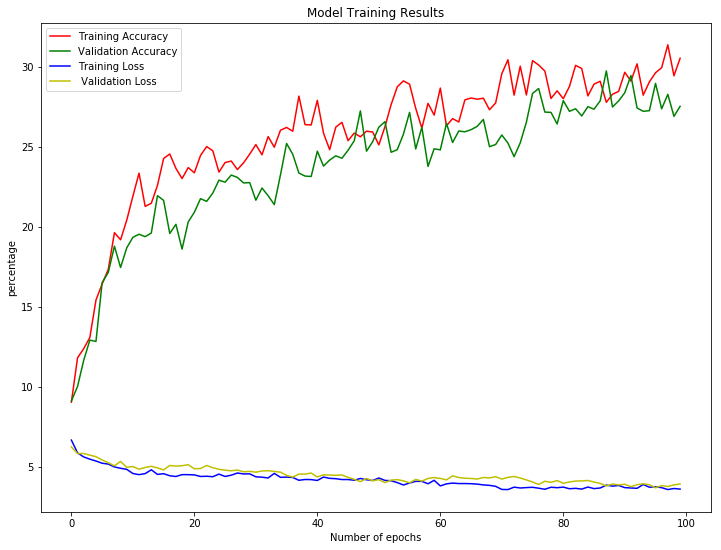

In [157]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [12,9]
plt.plot([i*100 for i in metrics.history['acc']],'r',label="Training Accuracy")
plt.plot([i*100 for i in metrics.history['val_acc']],'g',label="Validation Accuracy")
plt.plot(metrics.history['loss'],'b',label="Training Loss")
plt.plot([i for i in metrics.history['val_loss']],'y',label=" Validation Loss")
plt.ylabel('percentage')
plt.xlabel('Number of epochs')
plt.title('Model Training Results')
plt.legend()
 
# Set figure width to 12 and height to 9
plt.show()


In [12]:

# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

In [13]:
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
	# seed the generation process
	in_text = 'startseq'
	# iterate over the whole length of the sequence
	for i in range(max_length):
		# integer encode input sequence
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad input
		sequence = pad_sequences([sequence], maxlen=max_length)
		# predict next word
		yhat = model.predict([photo,sequence], verbose=0)
		# convert probability to integer
		yhat = argmax(yhat)
		# map integer to word
		word = word_for_id(yhat, tokenizer)
		# stop if we cannot map the word
		if word is None:
			break
		# append as input for generating the next word
		in_text += ' ' + word
		# stop if we predict the end of the sequence
		if word == 'endseq':
			break
	return in_text

### Calculate Confusion matrix for the test results 

In [18]:
from nltk.metrics.confusionmatrix import ConfusionMatrix
# Natural Language Toolkit: Confusion Matrices
# function to evaluate the confusion matrix for the test results
def confusion_matrix(model, descriptions, photos, tokenizer, max_length):
	actual, predicted = list(), list()
	# step over the whole set
	for key, desc_list in descriptions.items():
		# generate description
		yhat = (generate_desc(model, tokenizer, photos[key], max_length)).split()
		xhat = desc_list[0].split()        
		# store actual and predicted
		if len(yhat)>len(xhat):
			diff = len(yhat) - len(xhat)
			yhat = yhat[slice(len(yhat)-diff)]
		elif len(xhat)>len(yhat):
			diff = len(xhat) - len(yhat)
			xhat = xhat[slice(len(xhat)-diff)]
		actual.extend(xhat)
		predicted.extend(yhat)
	print(ConfusionMatrix(actual,predicted))
# prepare test set

# load test set
filename = 'Flickr8k_text/Flickr_8k.testImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))
# descriptions
test_descriptions = load_clean_descriptions('descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))
#print(test_descriptions)
# photo features
test_features = load_photo_features('features.pkl', test)
print('Photos: test=%d' % len(test_features))
# load the model
filename = 'model_inception99.h5'
model = load_model(filename)
confusion_matrix(model, test_descriptions, test_features, tokenizer, max_length)


Dataset: 1000
Descriptions: test=1000
Photos: test=1000
               |                                            a                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

AttributeError: 'NoneType' object has no attribute 'pretty_format'

In [93]:
# function evaluate bleu scores for the model
def calculte_bleu_score(model, descriptions, photos, tokenizer, max_length):
	bleu_scores = list()
	# step over the whole set
	for key, desc_list in descriptions.items():
		actual,predicted = list(),list()
		# generate description
		yhat = generate_desc(model, tokenizer, photos[key], max_length)
		# store actual and predicted
		references = [d.split() for d in desc_list]
		actual.append(references)
		predicted.append(yhat.split())
        # calculate BLEU score
		bleu_scores.append(corpus_bleu(actual,predicted ,weights=(1.0, 0, 0, 0)))
	return bleu_scores


### Evaluate and plot BLEU scores for the results 

Dataset: 1000
Descriptions: test=1000
Photos: test=1000
[0.2791881675133095, 0.2857142857142857, 0.25, 0.21470779802151024, 0.2982797722714565, 0.32206169703226534, 0.32206169703226534, 0.3333333333333333, 0.18612544500887301, 0.3333333333333333, 0.42857142857142855, 0.3333333333333333, 0.2857142857142857, 0.42857142857142855, 0.34967261396925226, 0.3333333333333333, 0.2727272727272727, 0.42857142857142855, 0.3980729503187718, 0.4444444444444444, 0.3333333333333333, 0.2857142857142857, 0.24767939992862334, 0.35588329018524795, 0.4444444444444444, 0.45454545454545453, 0.23884377019126307, 0.375, 0.2920502936517768, 0.37151909989293497, 0.2857142857142857, 0.4444444444444444, 0.2791881675133095, 0.13986904558770089, 0.3333333333333333, 0.21470779802151024, 0.375, 0.42857142857142855, 0.48404410457807934, 0.5555555555555556, 0.24767939992862334, 0.3333333333333333, 0.21470779802151024, 0.2982797722714565, 0.13986904558770089, 0.4953587998572467, 0.4444444444444444, 0.25, 0.209803568381551

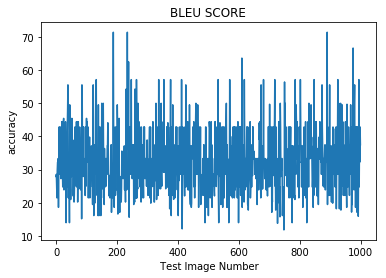

In [129]:
# evaluate bleu score
bleu_scores = evaluate_model_accuracy(model, test_descriptions, test_features, tokenizer, max_length)
print(bleu_scores)
plt.plot([i* 100 for i in bleu_scores])
plt.ylabel('accuracy')
plt.xlabel(' Test Image Number')
plt.title('BLEU SCORE')
plt.show()

### Evaluate and plot CHRF score for the test results 

[0.2643377003231831, 0.30007711685476396, 0.32762641359062555, 0.263931397732139, 0.4245894154844394, 0.27820635489620765, 0.21907943383704068, 0.23149796780751034, 0.2569010200580939, 0.38529970243780914, 0.2233821648433966, 0.2389699462873279, 0.2907083048639343, 0.3627886751802633, 0.29835078957846795, 0.2797587900921043, 0.32630006930334826, 0.393516659535492, 0.2728154133394227, 0.25807372628243036, 0.21824041290590288, 0.40280653576578285, 0.28598121721992276, 0.2014980357493733, 0.3938153901584363, 0.28243921381340653, 0.275680641148077, 0.44517943819250827, 0.22452132719388593, 0.23142724081343533, 0.3711286362897564, 0.3225661013293556, 0.23111282482826392, 0.2211527620261694, 0.30518835484802587, 0.23220309675135486, 0.21769594331308414, 0.27029294733047227, 0.27567535943073823, 0.36587816973151305, 0.289198324270829, 0.3793721493713271, 0.2023864622882402, 0.23562377254741, 0.19481475704752974, 0.28234200419314726, 0.2134779923866399, 0.2850797401908651, 0.20903654525352602,

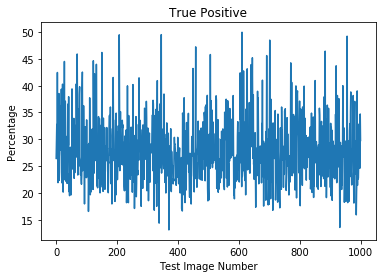

In [20]:
from nltk.metrics import *
from nltk.translate.chrf_score import corpus_chrf
import matplotlib.pyplot as plt
%matplotlib inline
# function to evaluate chrf scores  for the test results
def calculate_chrf_score(model, descriptions, photos, tokenizer, max_length):
	truepositive = list()
	# step over the whole set
	for key, desc_list in descriptions.items():
		# generate description
		yhat = generate_desc(model, tokenizer, photos[key], max_length)
		# store actual and predicted
		truepositive.append(corpus_chrf([desc_list[0].split()],[yhat.split()]))
	print(truepositive)
	return truepositive
tp = calculate_chrf_score(model, test_descriptions, test_features, tokenizer, max_length)
plt.plot([i* 100 for i in tp])
plt.ylabel('Percentage')
plt.xlabel('Test Image Number')
plt.title('True Positive')
plt.show()

In [95]:
# extract features from each photo in the directory
def extract_features(filename):
	# load the model
	model = InceptionV3(weights='imagenet')
	# re-structure the model
	model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
	# load the photo
	image = load_img(filename, target_size=(299, 299))
	# convert the image pixels to a numpy array
	image = img_to_array(image)
	# reshape data for the model
	image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))	
	# prepare the image for the VGG model
	image = preprocess_input(image)
	# get features
	feature = model.predict(image, verbose=0)
	return feature

### Predict the show the caption for one of test image using model

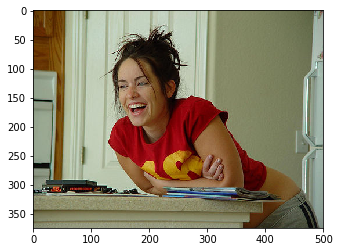

startseq girl in into wooden wooden endseq


In [99]:
import matplotlib.image as img
# load the tokenizer
tokenizer = load(open('tokenizer.pkl', 'rb'))
# pre-define the max sequence length (from training)
max_length = 34
# load the model
model = load_model('model_inception99.h5')
# load  and prepare the photograph
photo = extract_features('test.jpg')
# generate description
description = generate_desc(model, tokenizer, photo, max_length)
test_image = img.imread('test.jpg')
plt.imshow(test_image)
plt.show()
print(description)


### Reference for the code has been added in the Paper. 